In [1]:
import os
import random
import importlib
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
import torch

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import config
import model
import utility

In [4]:
importlib.reload(config)
importlib.reload(model)
importlib.reload(utility)

<module 'utility' from 'c:\\Users\\Administrator\\Documents\\GitHub\\TCN_portfolio\\utility.py'>

In [5]:
# Parse configs
configs = config.configs
parser = argparse.ArgumentParser(description='Setting configs')
utility.add_arguments(configs, parser)

args, unknown = parser.parse_known_args()
for arg in vars(args):
    value = getattr(args, arg)
    if value is not None:
        keys = arg.split(".")
        utility.nested_dict_update(value, configs, keys, indent=0)


#load data
if configs["portfolio_config"]["asset_pool"] == "sp500_sector_index":
    data_dict = {}
    SP500_index_data = pd.read_csv(os.path.join("data", "SP500_index.csv"), index_col=0).dropna()
    SP500_index_data.index = pd.to_datetime(SP500_index_data.index)
    SP500_index_data = SP500_index_data/SP500_index_data.iloc[0]

    SP500_index_return = (SP500_index_data/SP500_index_data.shift(1))[1:] - 1
    benchmark_return = SP500_index_return["S&P 500 (TR)"]
    benchmark_return.name = "S&P 500"
    asset_return = SP500_index_return.drop("S&P 500 (TR)", axis=1)
    asset_return.columns = asset_return.columns.str.replace("Select Sector Index TR", "").str.strip()
    init_weight = pd.read_csv(os.path.join("data", "SP500_sector_weight.csv"), header=1, index_col=0).dropna().T
    init_weight.index = pd.to_datetime(init_weight.index)
    init_weight_change = (init_weight/init_weight.shift(1))[1:] - 1
    assert (init_weight_change.columns.sort_values() == asset_return.columns.sort_values()).all()

    vix_index = pd.read_csv(os.path.join("data", "CBOE_VIX.csv"), index_col=0)["CLOSE"]
    vix_index.index = pd.to_datetime(vix_index.index)
    vix_index_return = (vix_index/vix_index.shift(1))[1:] - 1

    common_index = list(set(asset_return.index) & set(init_weight_change.index)& set(vix_index_return.index))
    asset_return = asset_return.loc[common_index].sort_index()
    benchmark_return = benchmark_return.loc[common_index].sort_index()
    init_weight_change = init_weight_change.loc[common_index].sort_index()
    vix_index_change = vix_index_return.loc[common_index].sort_index()

    tbond_index = pd.read_csv(os.path.join("data", "S&P U.S. Treasury Bond Index.csv"), index_col=0).dropna()["S&P U.S. Treasury Bond Index"]
    tbond_index.index = pd.to_datetime(tbond_index.index)
    tbond_index_return = (tbond_index/tbond_index.shift(1))[1:] - 1
    tbond_index_return = tbond_index_return.reindex(asset_return.index).fillna(0)

    og_index = pd.read_csv(os.path.join("data", "Dow Jones U.S. Oil & Gas Index.csv"), index_col=0).dropna(how="all", axis=0).dropna(how="all", axis=1)["Dow Jones U.S. Oil & Gas Total Return Index"]
    og_index.index = pd.to_datetime(og_index.index)
    og_index_return = (og_index/og_index.shift(1))[1:] - 1
    og_index_return = og_index_return.reindex(asset_return.index).fillna(0)

    gold_index = pd.read_csv(os.path.join("data", "Dow Jones Commodity Index Gold.csv"), index_col=0).dropna(how="all", axis=0).dropna(how="all", axis=1)["Dow Jones Commodity Index Gold TR"]
    gold_index.index = pd.to_datetime(gold_index.index)
    gold_index_return = (gold_index/gold_index.shift(1))[1:] - 1
    gold_index_return = gold_index_return.reindex(asset_return.index).fillna(0)

    ag_index = pd.read_csv(os.path.join("data", "S&P GSCI Agriculture.csv"), index_col=0).dropna(how="all", axis=0).dropna(how="all", axis=1)["S&P GSCI Agriculture TR"]
    ag_index.index = pd.to_datetime(ag_index.index)
    ag_index_return = (ag_index/ag_index.shift(1))[1:] - 1
    ag_index_return = ag_index_return.reindex(asset_return.index).fillna(0)

    #vix_index_change
    other_return = pd.concat([tbond_index_return, og_index_return, gold_index_return, ag_index_return], axis=1)
    
else:
    raise NotImplementedError(config.portfolio_config["asset_pool"] + "is not a valid asset pool.")

In [6]:
#pool_return = pd.concat([benchmark_return, tbond_index_return, og_index_return, gold_index_return, ag_index_return], axis=1)
pool_return =  pd.concat([tbond_index_return, asset_return], axis=1)

In [7]:
#configs["portfolio_config"]["model"] = "TCN"
configs["setting"]["plot"] = True
configs["hyperparameters_config"]["early_stop"] = 256
configs["hyperparameters_config"]["epoch"] = 1024
configs["hyperparameters_config"]["lr"] = 0.001
#configs["hyperparameters_config"]["optimization_target"] = "std"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
feature_list = [pool_return]
feature_op = [("None", 1)]
RNN_allocation_model = model.NNModel(pool_return, feature_list, feature_op, configs, "RNN", device)
LSTM_allocation_model = model.NNModel(pool_return, feature_list, feature_op, configs, "LSTM", device)
GRU_allocation_model = model.NNModel(pool_return, feature_list, feature_op, configs, "GRU", device)
TCN_allocation_model = model.NNModel(pool_return, feature_list, feature_op, configs, "TCN", device)

In [9]:
eq_allocation_model = model.BaseModel(pool_return, configs)
eq_result = eq_allocation_model.vanilla_backtesting()

mk_allocation_model = model.Markowitz(pool_return, configs)
mk_result = mk_allocation_model.vanilla_backtesting()

rp_allocation_model = model.RiskParity(pool_return, configs)
rp_result = rp_allocation_model.vanilla_backtesting()


TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00
TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00
TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00


TRAINING:  2014-04-14 00:00:00 2019-09-16 00:00:00
VALIDATION:  2019-09-17 00:00:00 2021-07-08 00:00:00


Epoch: 326, Training Loss: -0.9242514967918396, Validation Loss: -0.1005079373717308:  32%|███▏      | 326/1024 [00:13<00:31, 22.22it/s]   

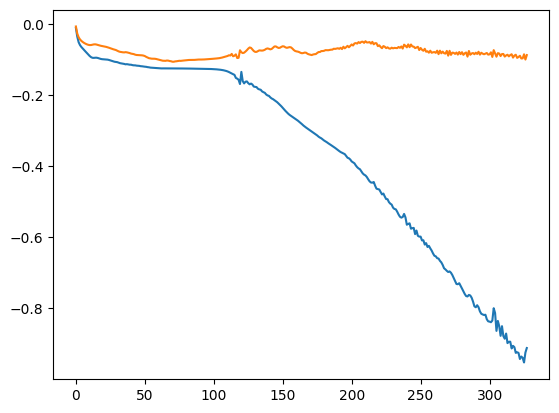

Epoch: 326, Training Loss: -0.9242514967918396, Validation Loss: -0.1005079373717308:  32%|███▏      | 327/1024 [00:14<00:30, 23.10it/s]


TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00
TRAINING:  2014-04-14 00:00:00 2019-09-16 00:00:00
VALIDATION:  2019-09-17 00:00:00 2021-07-08 00:00:00


Epoch: 316, Training Loss: -0.12543879449367523, Validation Loss: -0.10348015278577805:  31%|███       | 317/1024 [00:17<00:37, 18.63it/s]

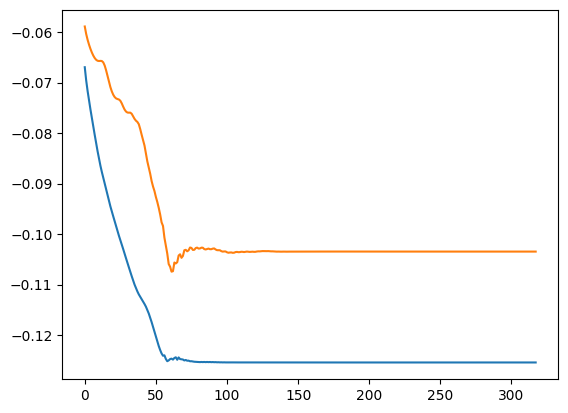

Epoch: 316, Training Loss: -0.12543879449367523, Validation Loss: -0.10348015278577805:  31%|███       | 317/1024 [00:17<00:39, 17.81it/s]


TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00
TRAINING:  2014-04-14 00:00:00 2019-09-16 00:00:00
VALIDATION:  2019-09-17 00:00:00 2021-07-08 00:00:00


Epoch: 589, Training Loss: -0.3948458433151245, Validation Loss: -0.0003649452410172671:  58%|█████▊    | 589/1024 [00:36<00:27, 15.54it/s]

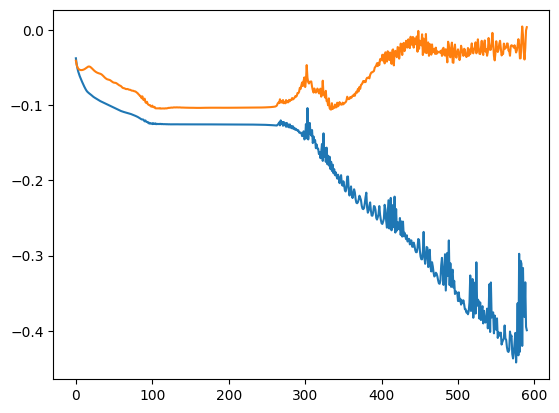

Epoch: 589, Training Loss: -0.3948458433151245, Validation Loss: -0.0003649452410172671:  58%|█████▊    | 590/1024 [00:37<00:27, 15.87it/s]


TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00
TRAINING:  2014-04-14 00:00:00 2019-09-16 00:00:00
VALIDATION:  2019-09-17 00:00:00 2021-07-08 00:00:00


Epoch: 441, Training Loss: -1.0070987939834595, Validation Loss: -0.03580982983112335:  43%|████▎     | 441/1024 [00:32<00:42, 13.65it/s] 

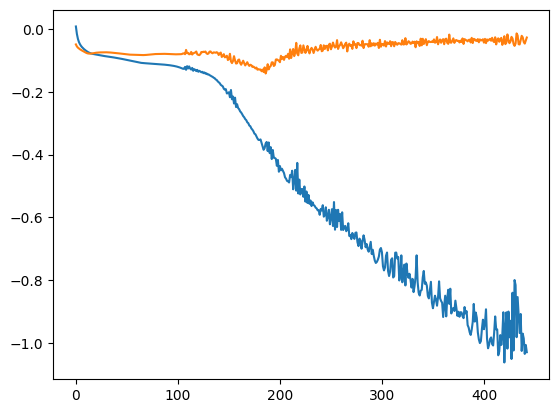

Epoch: 441, Training Loss: -1.0070987939834595, Validation Loss: -0.03580982983112335:  43%|████▎     | 442/1024 [00:33<00:43, 13.38it/s]


TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00


In [10]:
RNN_result = RNN_allocation_model.vanilla_backtesting()
LSTM_result = LSTM_allocation_model.vanilla_backtesting()
GRU_result = GRU_allocation_model.vanilla_backtesting()
TCN_result = TCN_allocation_model.vanilla_backtesting()

0.05880542770893593 0.007091914961669893
0.020296547325747337 0.004212833143255985
0.057286531964498885 0.007364590960292527
0.1253498760827523 0.0012634165226357865
0.18748544237495757 0.0015880633135338831
0.12487319013515633 0.0012704233102458625
0.3597379866507514 0.0019352620833334544


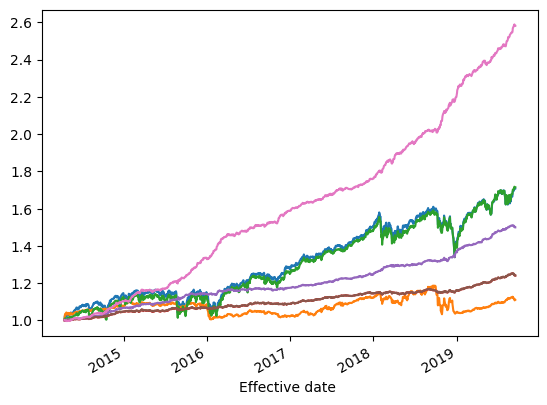

----------------------------------------
0.05105626407974102 0.015671367953541612
0.06789912655774435 0.004360844948368331
0.05092413181475258 0.01673545463321833
0.10655682010894721 0.0022780407421410533
0.10570269316434375 0.003093103326699164
0.10733940918811033 0.0023058258037557747
0.1413120961238788 0.004685379663605225


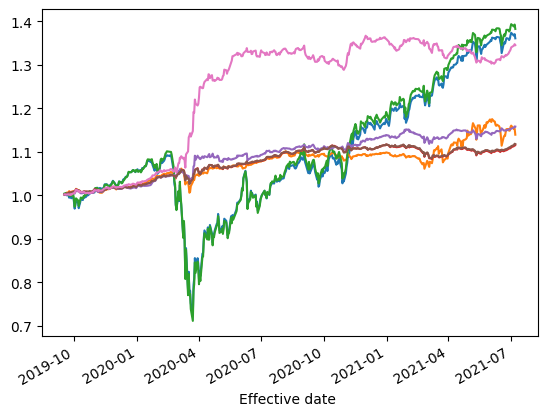

----------------------------------------
0.014017086469280009 0.01061896769271826
0.015606391342756503 0.015219796544348541
0.017983579861937857 0.009006340190755151
-0.04319401726281952 0.003163939796989631
-0.03811019565853899 0.003968132029320156
-0.04278437611811375 0.00320407428452576
0.021631351800816014 0.004171129784422091


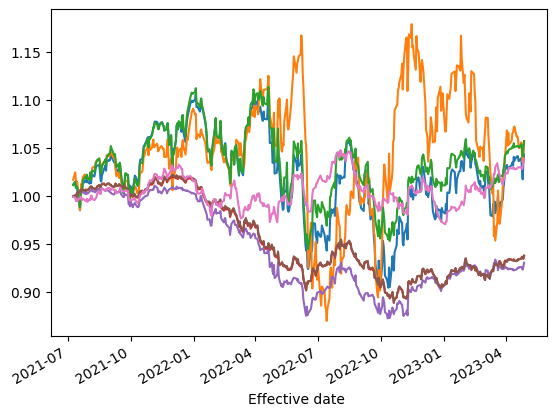

----------------------------------------


In [11]:
for i in range(3):
    print(eq_result[i].mean() / eq_result[i].std(), eq_result[i].std())
    print(mk_result[i].mean() / mk_result[i].std(), mk_result[i].std())
    print(rp_result[i].mean() / rp_result[i].std(), rp_result[i].std())
    print(RNN_result[i].mean() / RNN_result[i].std(), RNN_result[i].std())
    print(GRU_result[i].mean() / GRU_result[i].std(), GRU_result[i].std())
    print(LSTM_result[i].mean() / LSTM_result[i].std(), LSTM_result[i].std())
    print(TCN_result[i].mean() / TCN_result[i].std(), TCN_result[i].std())

    eq_result[i].add(1).cumprod().plot()
    mk_result[i].add(1).cumprod().plot()
    rp_result[i].add(1).cumprod().plot()
    RNN_result[i].add(1).cumprod().plot()
    GRU_result[i].add(1).cumprod().plot()
    LSTM_result[i].add(1).cumprod().plot()
    TCN_result[i].add(1).cumprod().plot()
    #benchmark_result = benchmark_return[TCN_result_1[i].index[0]:TCN_result_1[i].index[-1]]
    #benchmark_result.add(1).cumprod().plot()
    #print(benchmark_result.mean() / benchmark_result.std())
    plt.show()
    print("----------------------------------------")